# **Mental Health Prediction for Kenyan university students**

##### **Authors**:
<ul type='square'> 
    <li> Alice Wamuyu</li>
    <li> Eugene Kuloba </li>
    <li> Fridah Kimathi </li>
    <li> Karen Amanya  </li>
    <li> Nicholus Magak  </li>
    <li> Nobert Akwir </li>
</ul>

#  **1. Business Understanding**

## **Objectives**

> ### **General Objective**

> ### **Specific Objectives**
<ul type='square'>
    <li >  </li>
    <li>  </li>
    <li>  </li>
    <li>  </li>
    <li>  </li>
    <li>  </li>
</ul>



### **Importing the required libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')
import string
from textblob import TextBlob, Word
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  accuracy_score, classification_report, log_loss

# **2. Data Understanding**

The data used in this project is from the <a href="https://zindi.africa/competitions/basic-needs-basic-rights-kenya-tech4mentalhealth/data">  Basic Needs Basic Rights Kenya - Tech4MentalHealth</a> competition hosted by Zindi Africa. The data consists of statements and questions expressed by students from multiple universities across Kenya who reported suffering from these different mental health challenges. The wording of the statements is intended to respond to the prompting question, “What is on your mind?”

#### **Loading the data**

In [2]:
train_df = pd.read_csv('Data/Train.csv')
validation_df = pd.read_csv('Data/Test.csv')

In [3]:
# shape of the datasets
print(f'The train data shape: {train_df.shape}')
print(f'The test data shape: {validation_df.shape}')

The train data shape: (616, 3)
The test data shape: (309, 2)


In [4]:
# the columns in the datasets
print(f'The train data columns: \n {train_df.columns} \n')
print(f'The test data columns: \n {validation_df.columns}')

The train data columns: 
 Index(['ID', 'text', 'label'], dtype='object') 

The test data columns: 
 Index(['ID', 'text'], dtype='object')


In [5]:
# Checking for the shape, column names and data types 
print(f'The train data info: {train_df.info()} \n \n')
print(f'The test data info: {validation_df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB
The train data info: None 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      309 non-null    object
 1   text    309 non-null    object
dtypes: object(2)
memory usage: 5.0+ KB
The test data info: None


In [6]:
# classes proportionality 
train_df['label'].value_counts(normalize=True)

    # There is a slight class imbalance.

Depression    0.571429
Alcohol       0.227273
Suicide       0.107143
Drugs         0.094156
Name: label, dtype: float64

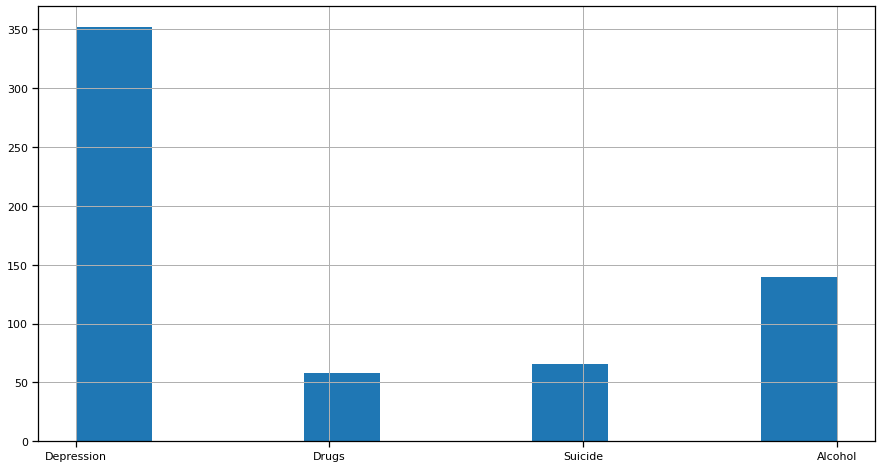

In [7]:
# Visualizing the proportionality of the target

train_df['label'].hist(figsize=(15,8));

In [8]:
# Creating a new column length showing the length of test per column
train_df['length'] =  train_df['text'].apply(len)
train_df['length']

0      39
1      28
2      57
3      22
4      51
       ..
611    36
612    30
613    24
614    16
615    31
Name: length, Length: 616, dtype: int64

In [9]:
# Statistical summary of the dataframe 
train_df.describe()

# The smallest statement is 8 words long
# The biggest statement is 196 words long

,length
count,616.000000
mean,39.813312
std,21.438797
min,8.000000
25%,26.000000
50%,35.000000
75%,48.250000
max,196.000000


In [10]:
# Viewing the statement with the most words

train_df[train_df['length'] == 196]

,ID,text,label,length
194,J55053XP,I am financially constrained over school fees ...,Depression,196


In [11]:
# Viewing the statement with the most words

print(train_df['text'].iloc[194])

I am financially constrained over school fees and my  family background is not stable with a lot of debts…I have an elderly brother who could easily support me but has no job even after graduating


 #### **Visualizing the distribution of the number of words per text**

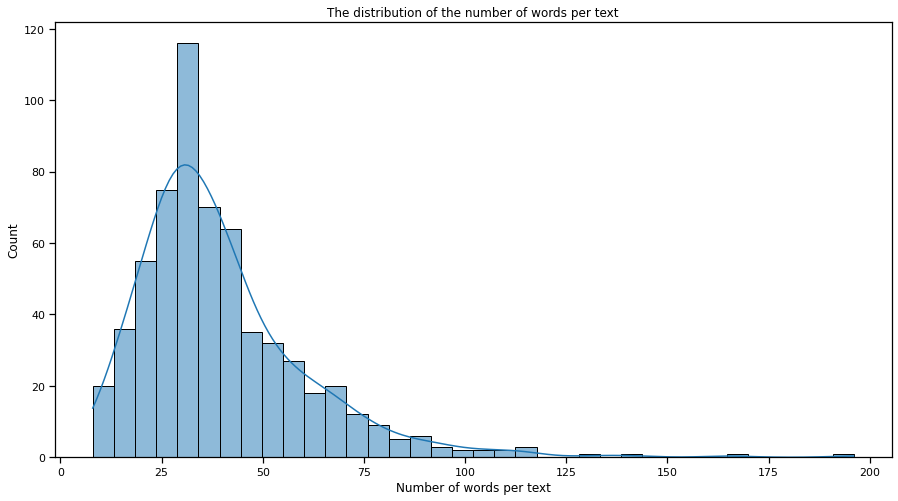

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(train_df['length'],ax=ax, kde=True)
ax.set_ylabel("Count")
ax.set_xlabel("Number of words per text")
ax.set_title("The distribution of the number of words per text");

# Observations:
    # The average text length lies between 25 and 40 words

 #### **Visualizing the effect of the number of words per text to the mental health status**

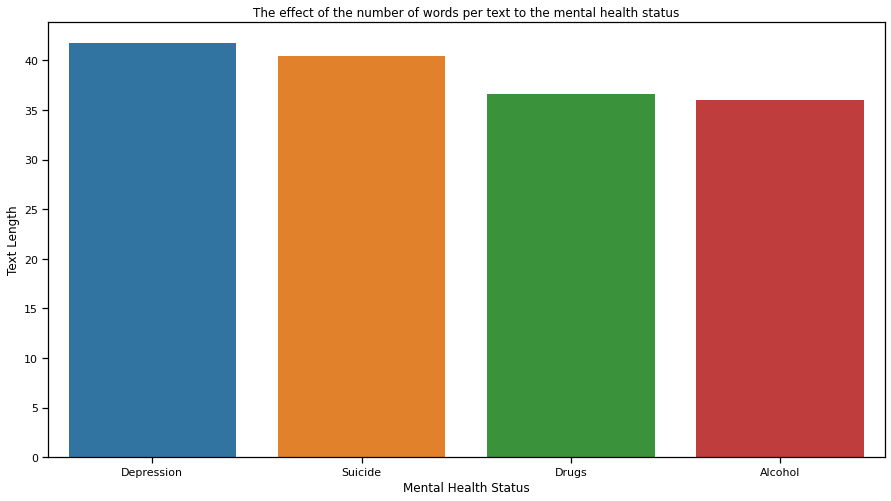

In [13]:
avg_text_length = train_df.groupby("label").mean().sort_values(by='length', ascending=False)

fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x=avg_text_length.index,y=avg_text_length.length, ax=ax)
ax.set_ylabel("Text Length")
ax.set_xlabel("Mental Health Status")
ax.set_title("The effect of the number of words per text to the mental health status");

# Observations:
    #Depression has the highest number of words per text on average followed closely by Suicide.
    # Alcohol and drugs have almost the same number of words per text which makes sense since alcohol is also a type of a drug.

# **3. Data Preparation**

 #### **i. Correcting spelling mistakes**

In [14]:
## To install textblob : conda install -c conda-forge textblob in terminal

def correct_sent(text):
    correction = TextBlob(text)
    correction = correction.correct()
    return str(correction)

train_df['corrected_sent'] = train_df['text'].apply(lambda x: correct_sent(x))
validation_df['corrected_sent'] = validation_df['text'].apply(lambda x: correct_sent(x))
train_df.head()

,ID,text,label,length,corrected_sent
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,39,I feel that it was better I die happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,28,Why do I get hallucinations?
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,57,I am stressed due to lack of financial support...
3,6UY7DX6Q,Why is life important?,Suicide,22,Why is life important?
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,51,Now could I be helped to go through the depres...


 #### **ii. Changing text to lowercase**

In [15]:
train_df['corrected_sent'] = train_df['corrected_sent'].apply(lambda x: x.lower())
validation_df['corrected_sent'] = validation_df['corrected_sent'].apply(lambda x: x.lower())
train_df.head()

,ID,text,label,length,corrected_sent
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,39,i feel that it was better i die happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,28,why do i get hallucinations?
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,57,i am stressed due to lack of financial support...
3,6UY7DX6Q,Why is life important?,Suicide,22,why is life important?
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,51,now could i be helped to go through the depres...


 #### **iii. Removing the punctuation marks**

In [16]:
# Checking texts with special characters such as â€¦ represented as …

for x in train_df['corrected_sent']:
    if '…' in x:
        print(x)

i feel hopeless, unworthy and useless …now do i cope with stress and forge the past?
i am facing a lot of challenges in life financially, emotional, psycologically and with no solutions…now can i safely look for solutions about depression on goose
there i get money for my needs…there do i get money  for personal needs?
i am financially constrained over school fees and my  family background is not stable with a lot of debts…i have an elderly brother who could easily support me but has no job even after granulating
i feel desperate…why is the world so unfair
by relatives deny me…i wonder if i am part of my family?


In [17]:
# Removing special characters â€¦ represented as …

train_df['corrected_sent'] = train_df['corrected_sent'].apply(lambda x: x.replace('…', ' '))
validation_df['corrected_sent'] = validation_df['corrected_sent'].apply(lambda x: x.replace('…', ' '))

In [18]:
# removing the other standard punctuation marks

train_df['corrected_sent'] = train_df['corrected_sent'].apply(lambda x: x.strip(string.punctuation))
validation_df['corrected_sent'] = validation_df['corrected_sent'].apply(lambda x: x.strip(string.punctuation))

train_df.head()

,ID,text,label,length,corrected_sent
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,39,i feel that it was better i die happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,28,why do i get hallucinations
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,57,i am stressed due to lack of financial support...
3,6UY7DX6Q,Why is life important?,Suicide,22,why is life important
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,51,now could i be helped to go through the depres...


 #### **iv. removing stop words**

In [19]:
# Downloading the necessary nltk packages. Uncomment to download

#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')

In [20]:
stopwords = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

def remove_stopwords(x):
    sent = [wordnet_lemmatizer.lemmatize(i, 'v') for i in x.split() if i not in stopwords]
    return ' '.join(sent)

train_df['no_stopwords'] = train_df['corrected_sent'].apply(lambda x: remove_stopwords(x))
validation_df['no_stopwords'] = validation_df['corrected_sent'].apply(lambda x: remove_stopwords(x))
train_df.head()

,ID,text,label,length,corrected_sent,no_stopwords
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,39,i feel that it was better i die happy,feel better die happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,28,why do i get hallucinations,get hallucinations
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,57,i am stressed due to lack of financial support...,stress due lack financial support school
3,6UY7DX6Q,Why is life important?,Suicide,22,why is life important,life important
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,51,now could i be helped to go through the depres...,could help go depression


 #### **iv. Tokenizing the sentences**

In [21]:
# tokenizing the sentences
#train_df['tokenized_text'] = train_df['no_stopwords'].apply(lambda x: nltk.word_tokenize(x))
#train_df.head()

#### **iv. Performing train test split**

In [22]:
train_label = train_df['label']
train_label

0      Depression
1           Drugs
2      Depression
3         Suicide
4      Depression
          ...    
611       Alcohol
612       Suicide
613       Alcohol
614    Depression
615    Depression
Name: label, Length: 616, dtype: object

In [23]:
#Encoding the train data
target={'Depression':0, 'Alcohol':1, 'Suicide':2, 'Drugs':3}

train_label = train_label.map(target)
train_label

0      0
1      3
2      0
3      2
4      0
      ..
611    1
612    2
613    1
614    0
615    0
Name: label, Length: 616, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, test_size=0.2 , random_state=42)


 #### **v. Vectorization**

In [25]:
# Instantiate countvectorizer
countvec = CountVectorizer(ngram_range=(1,1))
countvec1 = CountVectorizer(ngram_range=(1,1))

# Vectorization of the data
count_train_data = countvec.fit_transform(X_train.no_stopwords)
count_test_data = countvec.transform(X_test.no_stopwords)

count_training_data = countvec1.fit_transform(train_df.no_stopwords)
count_validation_data = countvec1.transform(validation_df.no_stopwords)


X_train= pd.DataFrame(count_train_data.toarray(), columns=countvec.get_feature_names())
X_test  = pd.DataFrame(count_test_data.toarray(), columns=countvec.get_feature_names())

train_data= pd.DataFrame(count_training_data.toarray(), columns=countvec1.get_feature_names())
validation_data= pd.DataFrame(count_validation_data.toarray(), columns=countvec1.get_feature_names())

X_train.head(3)

,abandon,able,absent,abuse,academic,add,addict,addition,adduct,adults,...,world,worry,worst,worth,worthless,would,wrap,yet,young,youths
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **3. Modelling**

In [26]:
#Models to be tested
models = { 'Model' : ['Baseline Decision Tree', 'Baseline KNN Classifier', 'Baseline Random Forest Classifier',\
                      'Baseline Adaboost Classifier', 'Baseline Gradient Boost', 'baseline XGBoost Classifier',\
                        'XGBoost Classifier-Grid Search'],
          'Train Accuracy Score(%)': [0, 0, 0, 0, 0, 0, 0],
          'Test Accuracy Score(%)': [0, 0, 0, 0, 0, 0, 0],
          'Train Log_loss': [0, 0, 0, 0, 0, 0, 0],
          'Test Log_loss': [0, 0, 0, 0, 0, 0, 0] }
          

#Dataframe holding the model names and accuracy score
df_model_results = pd.DataFrame(models, columns=['Model','Train Accuracy Score(%)', 'Test Accuracy Score(%)', 'Train Log_loss', 'Test Log_loss'])


#Function to fill the dataframe holding model names and accuracy score

def model_results(model_type, y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob):
  index_val = df_model_results[df_model_results['Model']==model_type].index

  df_model_results.loc[index_val, 'Train Accuracy Score(%)'] = round(accuracy_score(y_train, y_train_pred), 2)*100
  df_model_results.loc[index_val, 'Test Accuracy Score(%)'] = round(accuracy_score(y_test, y_test_pred), 2)*100
  df_model_results.loc[index_val, 'Train Log_loss'] = log_loss(y_train, y_train_pred_prob, labels=[0,1,2,3])
  df_model_results.loc[index_val, 'Test Log_loss'] = log_loss(y_test, y_test_pred_prob, labels=[0,1,2,3])

  return df_model_results

>> <b>i. Decision Tree Classifier</b>

In [27]:
baseline_dt = DecisionTreeClassifier(random_state=100)

baseline_dt.fit(X_train, y_train)

y_test_pred_prob = baseline_dt.predict_proba(X_test)
y_train_pred_prob = baseline_dt.predict_proba(X_train)

y_test_pred = baseline_dt.predict(X_test)
y_train_pred = baseline_dt.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('Baseline Decision Tree',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

#Observation:
     # Despite the fact that suicide has more data than drugs, it performs worse than it
     # There is overfitting 

*********************************************************************
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        63
           1       0.84      0.93      0.88        28
           2       0.62      0.50      0.55        16
           3       1.00      0.71      0.83        17

    accuracy                           0.83       124
   macro avg       0.82      0.76      0.78       124
weighted avg       0.83      0.83      0.83       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.59081
1,Baseline KNN Classifier,0.0,0.0,0.000000,0.00000
2,Baseline Random Forest Classifier,0.0,0.0,0.000000,0.00000
3,Baseline Adaboost Classifier,0.0,0.0,0.000000,0.00000
4,Baseline Gradient Boost,0.0,0.0,0.000000,0.00000
5,baseline XGBoost Classifier,0.0,0.0,0.000000,0.00000
6,XGBoost Classifier-Grid Search,0.0,0.0,0.000000,0.00000


>> <b>ii. KNN Classifier</b>

In [28]:
baseline_knn = KNeighborsClassifier()

baseline_knn.fit(X_train, y_train)

y_test_pred_prob = baseline_knn.predict_proba(X_test)
y_train_pred_prob = baseline_knn.predict_proba(X_train)

y_test_pred = baseline_knn.predict(X_test)
y_train_pred = baseline_knn.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('Baseline KNN Classifier',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

# Observation
 # KNN performs worse than decision tree

*********************************************************************
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        63
           1       0.77      0.82      0.79        28
           2       0.89      0.50      0.64        16
           3       1.00      0.41      0.58        17

    accuracy                           0.79       124
   macro avg       0.86      0.67      0.72       124
weighted avg       0.82      0.79      0.77       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.590810
1,Baseline KNN Classifier,87.0,79.0,0.316615,2.355406
2,Baseline Random Forest Classifier,0.0,0.0,0.000000,0.000000
3,Baseline Adaboost Classifier,0.0,0.0,0.000000,0.000000
4,Baseline Gradient Boost,0.0,0.0,0.000000,0.000000
5,baseline XGBoost Classifier,0.0,0.0,0.000000,0.000000
6,XGBoost Classifier-Grid Search,0.0,0.0,0.000000,0.000000


>> <b>iii. Random Forest Classifier</b>

In [29]:
baseline_rf = RandomForestClassifier(random_state=0)

baseline_rf.fit(X_train, y_train)

y_test_pred_prob = baseline_rf.predict_proba(X_test)
y_train_pred_prob = baseline_rf.predict_proba(X_train)

y_test_pred = baseline_rf.predict(X_test)
y_train_pred = baseline_rf.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('Baseline Random Forest Classifier',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

# Observation 
 # Random Forest performs better than Decision Tree and KNN


*********************************************************************
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        63
           1       0.76      0.89      0.82        28
           2       0.75      0.38      0.50        16
           3       0.92      0.65      0.76        17

    accuracy                           0.81       124
   macro avg       0.81      0.71      0.74       124
weighted avg       0.82      0.81      0.80       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.590810
1,Baseline KNN Classifier,87.0,79.0,0.316615,2.355406
2,Baseline Random Forest Classifier,99.0,81.0,0.106574,0.775972
3,Baseline Adaboost Classifier,0.0,0.0,0.000000,0.000000
4,Baseline Gradient Boost,0.0,0.0,0.000000,0.000000
5,baseline XGBoost Classifier,0.0,0.0,0.000000,0.000000
6,XGBoost Classifier-Grid Search,0.0,0.0,0.000000,0.000000


>> <b>iv. Adaboost Classifier</b>

In [30]:
baseline_adaboost = AdaBoostClassifier(random_state=0)

baseline_adaboost.fit(X_train, y_train)

y_test_pred_prob = baseline_adaboost.predict_proba(X_test)
y_train_pred_prob = baseline_adaboost.predict_proba(X_train)

y_test_pred = baseline_adaboost.predict(X_test)
y_train_pred = baseline_adaboost.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('Baseline Adaboost Classifier',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

# Observations:
 # Adaboost performs worse than all the previous models
 # There is overfitting


*********************************************************************
              precision    recall  f1-score   support

           0       0.74      0.95      0.83        63
           1       0.92      0.79      0.85        28
           2       0.67      0.25      0.36        16
           3       0.69      0.53      0.60        17

    accuracy                           0.77       124
   macro avg       0.75      0.63      0.66       124
weighted avg       0.76      0.77      0.74       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.590810
1,Baseline KNN Classifier,87.0,79.0,0.316615,2.355406
2,Baseline Random Forest Classifier,99.0,81.0,0.106574,0.775972
3,Baseline Adaboost Classifier,85.0,77.0,1.031080,1.059045
4,Baseline Gradient Boost,0.0,0.0,0.000000,0.000000
5,baseline XGBoost Classifier,0.0,0.0,0.000000,0.000000
6,XGBoost Classifier-Grid Search,0.0,0.0,0.000000,0.000000


>> <b>v. Gradient Boost Classifier</b>

In [31]:
baseline_gradientboost = GradientBoostingClassifier(random_state=0)

baseline_gradientboost.fit(X_train, y_train)

y_test_pred_prob = baseline_gradientboost.predict_proba(X_test)
y_train_pred_prob = baseline_gradientboost.predict_proba(X_train)

y_test_pred = baseline_gradientboost.predict(X_test)
y_train_pred = baseline_gradientboost.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('Baseline Gradient Boost',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

# Observations:
 # Gradient boost performs better than all models except Random Forest


*********************************************************************
              precision    recall  f1-score   support

           0       0.82      0.94      0.87        63
           1       0.89      0.89      0.89        28
           2       0.58      0.44      0.50        16
           3       1.00      0.71      0.83        17

    accuracy                           0.83       124
   macro avg       0.82      0.74      0.77       124
weighted avg       0.83      0.83      0.82       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.590810
1,Baseline KNN Classifier,87.0,79.0,0.316615,2.355406
2,Baseline Random Forest Classifier,99.0,81.0,0.106574,0.775972
3,Baseline Adaboost Classifier,85.0,77.0,1.031080,1.059045
4,Baseline Gradient Boost,97.0,83.0,0.163581,0.509805
5,baseline XGBoost Classifier,0.0,0.0,0.000000,0.000000
6,XGBoost Classifier-Grid Search,0.0,0.0,0.000000,0.000000


>> <b>vi. XGBoost Classifier</b>

In [32]:
xgboost_classifier = XGBClassifier()

xgboost_classifier.fit(X_train, y_train)

y_test_pred_prob = xgboost_classifier.predict_proba(X_test)
y_train_pred_prob = xgboost_classifier.predict_proba(X_train)

y_test_pred = xgboost_classifier.predict(X_test)
y_train_pred = xgboost_classifier.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('baseline XGBoost Classifier',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

# Observations:
    # xgboost classifier performs slightly better than random forest classifier making it the best model so far.

*********************************************************************
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        63
           1       0.89      0.89      0.89        28
           2       0.71      0.62      0.67        16
           3       1.00      0.65      0.79        17

    accuracy                           0.85       124
   macro avg       0.86      0.78      0.81       124
weighted avg       0.85      0.85      0.84       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.590810
1,Baseline KNN Classifier,87.0,79.0,0.316615,2.355406
2,Baseline Random Forest Classifier,99.0,81.0,0.106574,0.775972
3,Baseline Adaboost Classifier,85.0,77.0,1.031080,1.059045
4,Baseline Gradient Boost,97.0,83.0,0.163581,0.509805
5,baseline XGBoost Classifier,93.0,85.0,0.219129,0.451154
6,XGBoost Classifier-Grid Search,0.0,0.0,0.000000,0.000000


>> <b> Tuning XGboost model</b>

In [33]:
Tuned_xgboost = XGBClassifier()
param_grid = {'learning_rate': [0.1,0.2],
               'max_depth': [4, 6, 10],
               'n_estimators':[100,200, 300, 500]}


xgbclassifier_grid_search = GridSearchCV(Tuned_xgboost, param_grid, scoring='accuracy', cv=3, n_jobs=1)

xgbclassifier_grid_search.fit(X_train, y_train)

y_test_pred_prob = xgbclassifier_grid_search.predict_proba(X_test)
y_train_pred_prob = xgbclassifier_grid_search.predict_proba(X_train)

y_test_pred = xgbclassifier_grid_search.predict(X_test)
y_train_pred = xgbclassifier_grid_search.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('XGBoost Classifier-Grid Search',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)



*********************************************************************
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        63
           1       0.86      0.89      0.88        28
           2       0.71      0.62      0.67        16
           3       1.00      0.65      0.79        17

    accuracy                           0.85       124
   macro avg       0.85      0.78      0.80       124
weighted avg       0.85      0.85      0.84       124

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss
0,Baseline Decision Tree,99.0,83.0,0.012334,5.590810
1,Baseline KNN Classifier,87.0,79.0,0.316615,2.355406
2,Baseline Random Forest Classifier,99.0,81.0,0.106574,0.775972
3,Baseline Adaboost Classifier,85.0,77.0,1.031080,1.059045
4,Baseline Gradient Boost,97.0,83.0,0.163581,0.509805
5,baseline XGBoost Classifier,93.0,85.0,0.219129,0.451154
6,XGBoost Classifier-Grid Search,92.0,85.0,0.241682,0.439006


In [34]:
# XGBoost Best Parameters
xgbclassifier_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}

# Final Model

<i>The chosen  final model is the XGBoost Classifier</i>

In [35]:
final_model = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=300)
 
final_model.fit(train_data, train_label)

preds = final_model.predict_proba(validation_data)


In [36]:

id = pd.DataFrame(validation_df['ID'])
predicted = pd.DataFrame(preds, columns=['Depression', 'Alcohol', 'Suicide', 'Drugs'])
predicted_status = pd.concat([id,predicted], axis=1)

#Saving file as a CSV
predicted_status.to_csv('Data/predicted_status.csv',encoding='utf-8',sep=',', index=False)

# **4. Evaluation**

# **Conclusion and recommendations**